### Dataset
https://www.kaggle.com/amanneo/diabetic-retinopathy-resized-arranged

### Carga librerías

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
import cv2
from matplotlib.image import imread
from tensorflow.keras import utils
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import ( Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, 
    GlobalMaxPooling2D, add)
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# montar google drive in colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Diabetic_Retinopathy_Project_DL/1_Data'

### Carga paths por clase

In [ ]:
ls_0 = ['0/'+s for s in os.listdir(f'{path}/0')]
ls_1 = ['1/'+s for s in os.listdir(f'{path}/1')]
ls_2 = ['2/'+s for s in os.listdir(f'{path}/2')]
ls_3 = ['3/'+s for s in os.listdir(f'{path}/3')]
ls_4 = ['4/'+s for s in os.listdir(f'{path}/4')]

In [ ]:
print(f'No DR:{len(ls_0)}\nMild DR: {len(ls_1)}\nModerate DR: {len(ls_2)}\nSevere DR: {len(ls_3)}\nProliferative DR: {len(ls_4)}')

No DR:25921
Mild DR: 2443
Moderate DR: 5292
Severe DR: 873
Proliferative DR: 708


In [ ]:
s_ls_0 = random.sample(ls_0,300)
s_ls_1 = random.sample(ls_1,300)
s_ls_2 = random.sample(ls_2,300)
s_ls_3 = random.sample(ls_3,300)
s_ls_4 = random.sample(ls_4,300)

### Muestra imágenes por clase

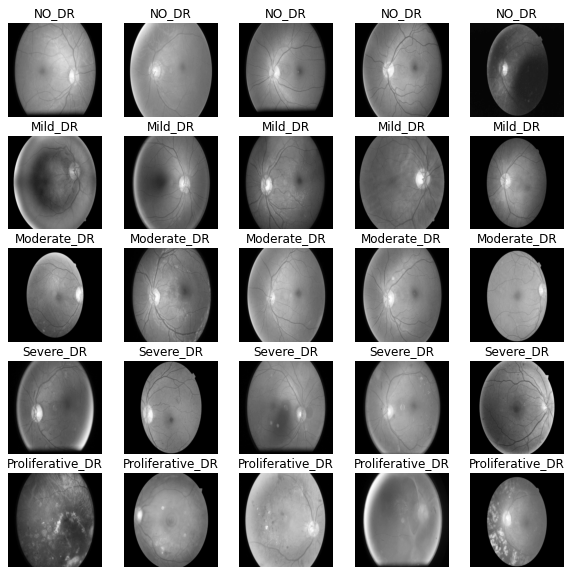

In [ ]:
#ploteo muestras aleatoarias a color.

fig = plt.figure(figsize =(10,10))
for i in range(25):
  if i < 5:
    fp = f'{path}/{s_ls_0[i]}'
    label = 'NO_DR'
  elif 5<=i<10:
    fp = f'{path}/{s_ls_1[i-5]}'
    label = 'Mild_DR'
  elif 10<=i<15:
    fp = f'{path}/{s_ls_2[i-10]}'
    label = 'Moderate_DR'
  elif 15<=i<20:
    fp = f'{path}/{s_ls_3[i-15]}'
    label = 'Severe_DR'
  else:
    fp = f'{path}/{s_ls_4[i-20]}'
    label = 'Proliferative_DR'

  ax = fig.add_subplot(5, 5, i+1)

  #fn = image.load_img(fp, target_size = (240,240), color_mode='grayscale')
  img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
  resized = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA)
  #cv2_imshow(resized)
  plt.imshow(resized, cmap='gray')
  #plt.imshow(fn)
  plt.title(label)
  plt.axis('off')

plt.show()

### Interpolación reducción de pixeles

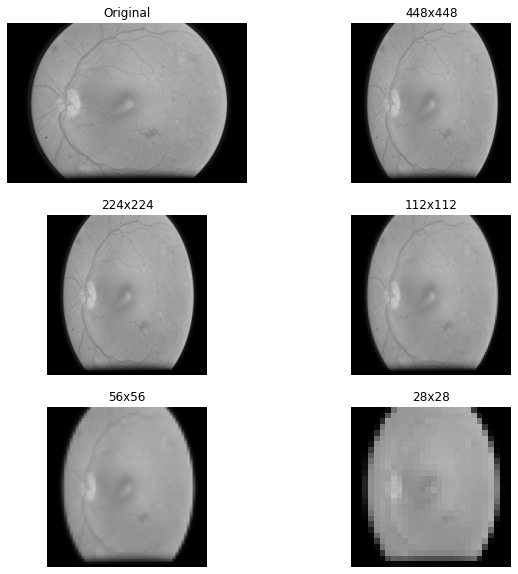

<Figure size 432x288 with 0 Axes>

In [ ]:
reshape1 = cv2.resize(img, (448, 448), interpolation = cv2.INTER_AREA)
reshape2 = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
reshape3 = cv2.resize(img, (112, 112), interpolation = cv2.INTER_AREA)
reshape4 = cv2.resize(img, (56, 56), interpolation = cv2.INTER_AREA)
reshape5 = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)

Titles =["Original", "448x448", "224x224", "112x112", "56x56", "28x28"]
images =[img, reshape1, reshape2, reshape3, reshape4, reshape5]

fig = plt.figure(figsize =(10,10))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.title(Titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
plt.tight_layout()

### Baseline model

In [ ]:
x_train_0 = random.sample(s_ls_0,int(0.7*300))
x_train_1 = random.sample(s_ls_1,int(0.7*300))
x_train_2 = random.sample(s_ls_2,int(0.7*300))
x_train_3 = random.sample(s_ls_3,int(0.7*300))
x_train_4 = random.sample(s_ls_4,int(0.7*300))
x_train = x_train_0+x_train_1+x_train_2+x_train_3+x_train_4
x_test = [x for x in s_ls_0 if x not in x_train_0]+[x for x in s_ls_1 if x not in x_train_1]+[x for x in s_ls_2 if x not in x_train_2]+[x for x in s_ls_3 if x not in x_train_3]+[x for x in s_ls_4 if x not in x_train_4]

y_train = [0]*int(0.7*300)+[1]*int(0.7*300)+[2]*int(0.7*300)+[3]*int(0.7*300)+[4]*int(0.7*300)
y_test = [0]*int(300-0.7*300)+[1]*int(300-0.7*300)+[2]*int(300-0.7*300)+[3]*int(300-0.7*300)+[4]*int(300-0.7*300)

In [ ]:
# NO CORRER

x_train_np = np.empty((len(x_train), 224, 224,3))

# tarda 10 min con shape (1050,224,224,3)
for i,img_path in enumerate(x_train):
  img = cv2.cvtColor(cv2.imread(path+'/'+img_path), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
  x_train_np[i,...] = img

In [ ]:
# NO CORRER
x_test_np = np.empty((len(x_test), 224, 224,3))

# tarda 4 min con shape (450,224,224,3)
for i,img_path in enumerate(x_test):
  img = cv2.cvtColor(cv2.imread(path+'/'+img_path), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
  x_test_np[i,...] = img

In [ ]:
# NO CORRER
np.save(path+'/x_train_v1.npy', x_train_np)
np.save(path+'/x_test_v1.npy', x_test_np)

In [ ]:
# Para cargar:
x_train_np = np.load(path+'/x_train_v1.npy')
x_test_np = np.load(path+'/x_test_v1.npy')

In [ ]:
y_train_np = np.array([y_train]).T
y_test_np = np.array([y_test]).T

## Baseline DL model

In [ ]:
num_classes = 5
y_train = utils.to_categorical(y_train_np, num_classes)
y_test = utils.to_categorical(y_test_np, num_classes)

train_datagen = image.ImageDataGenerator(
    featurewise_center=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True)
train_datagen.fit(x_train_np)

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen.fit(x_test_np)

In [ ]:
# add preprocessing layer to the front VGG
IMAGE_SIZE = [224,224]
mobilenet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# won't train existing weights
for layer in mobilenet.layers:
  layer.trainable = False

# extra layers to be trained
#x = Flatten()(vgg.output)
x = GlobalAveragePooling2D()(mobilenet.output)

#x = Dense(12544, activation='relu')(x)
#x = Dense(6272, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = Dense(3136, activation='relu')(x)
#x = Dense(1568, activation='relu')(x)
#x = Dropout(0.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

# Model object
model = Model(inputs=mobilenet.input, outputs=prediction)

# view model structure
model.summary()

# cost and optimization method for the model
model.compile(loss='categorical_crossentropy', 
              optimizer= Adam(),
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
epochs = 10

history = model.fit(train_datagen.flow(x_train_np, y_train, batch_size=32),
         validation_data=test_datagen.flow(x_test_np, y_test, batch_size=8),
         steps_per_epoch=len(x_train_np) / 32, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 53s 2s/step - loss: 1.2655 - accuracy: 0.4733 - val_loss: 1.4047 - val_accuracy: 0.3667
Epoch 2/10
32/32 [==============================] - 52s 2s/step - loss: 1.2855 - accuracy: 0.4457 - val_loss: 1.4255 - val_accuracy: 0.3733
Epoch 3/10
32/32 [==============================] - 52s 2s/step - loss: 1.2733 - accuracy: 0.4514 - val_loss: 1.4303 - val_accuracy: 0.3844
Epoch 4/10
32/32 [==============================] - 52s 2s/step - loss: 1.2322 - accuracy: 0.4724 - val_loss: 1.3994 - val_accuracy: 0.3644
Epoch 5/10
32/32 [==============================] - 53s 2s/step - loss: 1.2389 - accuracy: 0.4562 - val_loss: 1.4146 - val_accuracy: 0.3978
Epoch 6/10
32/32 [==============================] - 55s 2s/step - loss: 1.2218 - accuracy: 0.4952 - val_loss: 1.4259 - val_accuracy: 0.3800
Epoch 7/10
32/32 [==============================] - 54s 2s/step - loss: 1.2192 - accuracy: 0.4857 - val_loss: 1.4484 - val_accuracy: 0.3956
Epoch 8/10
32/32 [==

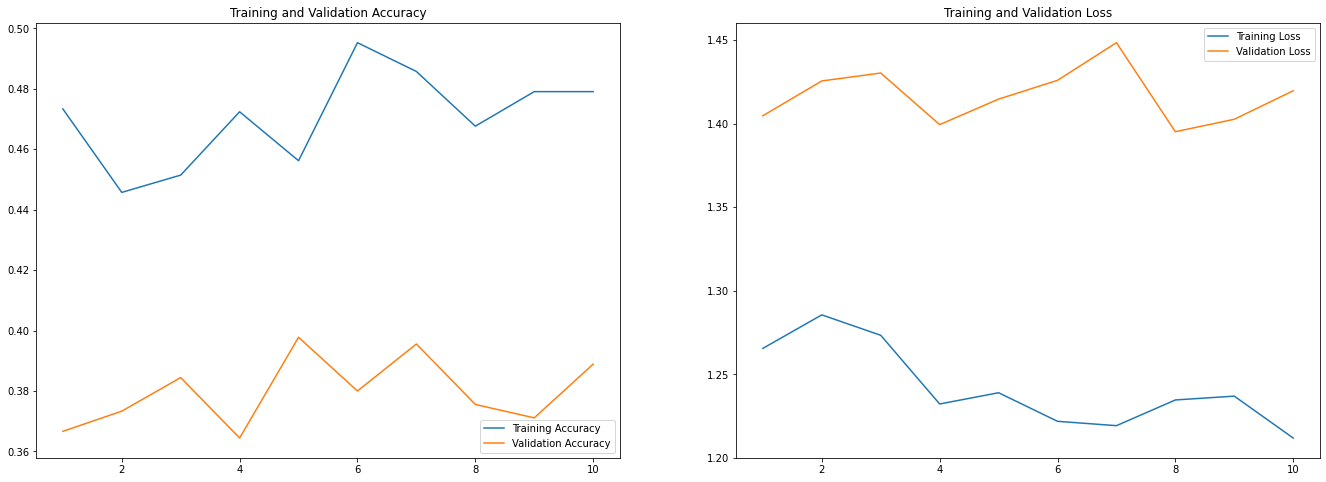

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_test_pred = model.predict(test_datagen.flow(x_test_np))
y_test_pred = np.round(y_test_pred)
y_test_pred_1d = np.argmax(y_test_pred, axis=1)

In [ ]:
print("Test Data")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred_1d))

Test Data
              precision    recall  f1-score   support

           0       0.21      0.62      0.32        90
           1       0.16      0.17      0.16        90
           2       0.33      0.02      0.04        90
           3       0.23      0.06      0.09        90
           4       0.22      0.16      0.18        90

    accuracy                           0.20       450
   macro avg       0.23      0.20      0.16       450
weighted avg       0.23      0.20      0.16       450



Test Data


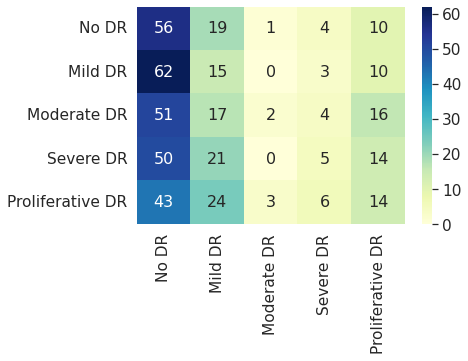

In [ ]:
# DISPLAY CONFUSION MATRIX
print("Test Data")
categories = ["No DR", "Mild DR", "Moderate DR", "Severe DR", "Proliferative DR"]
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_1d)
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size
plt.show()